## Task 1
In this task, you are going to implement and evaluate a **simplified** form of matrix factorization and SGD where you are going to **directly** update the parameters ``P`` and ``Q`` based on the direction that reduces the error (residual error) and learning rate using the Surprise class template for MovieLens-33M. NOTE THAT YOU CAN USE OTHER LIBRARIES/NO LIBRARIES TO IMPLEMENT SGD FROM SCRATCH IF YOU WANT.

1.1. Use the template below to implement the ``init()``, ``fit()``, and ``estimate()`` functions for the Matrix Factorization. You have to strictly follow this structure so that it is compatible with Surprise's functionalities and methods.

```
class MF(surprise.AlgoBase):
    def __init__(self,learning_rate,num_epochs,num_factors):
        
    def fit(self,train):
      
    def estimate(self,u,i):
        
```

1.2. Evaluate your implemented algorithm using 3-fold cross-validation to obtain the optimal hyperparameters for the ``learning rate``, ``num_factors``, and ``num_epochs`` with any appropriate loss function on the MovieLens dataset. MAKE SURE YOUR SEARCH SPACE IS SMALL SO THAT IT DOESNT TAKE TOO LONG (DAYS OF SEARCHING).

1.3. Demonstrate the effect of gradually increasing the ``num_factors`` hyperparameter in the algorithm (fixed learning rate and epochs (you should fetch these two hyperparameters from the results of 1.2)) on RSME by visualization (x-axis as num_factors and y-axis as RSME) and the hold out set is 20%. Explain and interpret the results (why does it increase/decrease?...etc.)

## Task 2
In this task, you will build a hybrid recommender system where you will combine the output of **2** recommendation algorithms to predict a rating of each test sample. You can use any library for this.

2.1. Train each of the 2 recommendation algorithms of your choice seperately with fixed hyperparameters on the same 80% training set. You can use the recommender system you have built in Task 1 as one of the algorithms to combine (if you will be using Surprise).

2.2. Build the hybrid recommender system where you will average the output rating from each algorithm for each test sample. You can also follow the same structure/format as in Task 1.

3.3. Evaluate each algorithm seperately and the hybrid system using **MAE** on the same 20% holdout set. Visualize the results. Which one performs the best? Does the hybrid improve the individual rating outputs? How do you think we can improve this system? Does assigning weights to the predictions make sense?


In [91]:

import numpy as np
import pandas as pd
from surprise import AlgoBase, Dataset, Reader, PredictionImpossible
from surprise.model_selection import cross_validate, GridSearchCV
import matplotlib.pyplot as plt
import os

%matplotlib inline


In [92]:

class MF(AlgoBase):

    def __init__(self, learning_rate, num_epochs, num_factors):
        AlgoBase.__init__(self)
        self.lr = learning_rate
        self.epochs = num_epochs
        self.n_factors = num_factors

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.pu = np.random.normal(0, .1, (trainset.n_users, self.n_factors))
        self.qi = np.random.normal(0, .1, (trainset.n_items, self.n_factors))

        for epoch in range(self.epochs):
            for u, i, r in trainset.all_ratings():
                dot = np.dot(self.pu[u], self.qi[i])
                err = r - dot
                self.pu[u] += self.lr * err * self.qi[i]
                self.qi[i] += self.lr * err * self.pu[u]
        return self

    def estimate(self, u, i):
        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            return np.dot(self.pu[u], self.qi[i])
        else:
            raise PredictionImpossible('User and/or item is unknown.')


In [93]:

file_path = os.path.expanduser('ml-latest-small/ratings.csv')

reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

data = Dataset.load_from_file(file_path, reader=reader)


In [94]:

param_grid = {
    'learning_rate': [0.005, 0.01],
    'num_epochs': [5, 10],
    'num_factors': [10, 20]
}

gs = GridSearchCV(MF, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

print(f'Best RMSE: {gs.best_score["rmse"]}')

print(f'Best parameters: {gs.best_params["rmse"]}')


Best RMSE: 0.9660703902360731
Best parameters: {'learning_rate': 0.01, 'num_epochs': 10, 'num_factors': 10}


In [95]:

print("Average RMSE scores for different numbers of factors:")
for factor, score in zip(factor_range, avg_rmse):
    print(f"Num Factors = {factor}: Average RMSE = {score}")
print() 


Average RMSE scores for different numbers of factors:
Num Factors = 5: Average RMSE = 0.960691870234519
Num Factors = 10: Average RMSE = 0.9653739994925771
Num Factors = 15: Average RMSE = 0.9697436062458147
Num Factors = 20: Average RMSE = 0.9776683178036584
Num Factors = 25: Average RMSE = 0.980093082572008
Num Factors = 30: Average RMSE = 0.9880784924136484
Num Factors = 35: Average RMSE = 0.9959157898973263
Num Factors = 40: Average RMSE = 0.9949567613867668



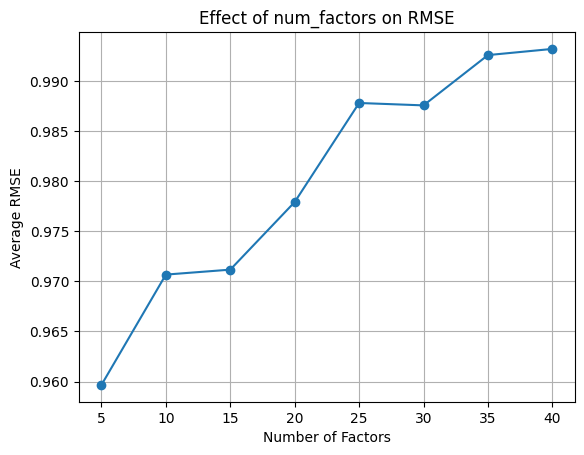

In [96]:

optimal_lr = gs.best_params['rmse']['learning_rate']
optimal_epochs = gs.best_params['rmse']['num_epochs']

factor_range = [5, 10, 15, 20, 25, 30, 35, 40]
avg_rmse = []

for factor in factor_range:
    algo = MF(learning_rate=optimal_lr, num_epochs=optimal_epochs, num_factors=factor)
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    avg_rmse.append(np.mean(results['test_rmse']))

plt.plot(factor_range, avg_rmse, marker='o')
plt.title('Effect of num_factors on RMSE')
plt.xlabel('Number of Factors')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.show()


In [97]:

from surprise import SVD, accuracy
from surprise.model_selection import train_test_split

optimal_lr = gs.best_params['rmse']['learning_rate']
optimal_epochs = gs.best_params['rmse']['num_epochs']
optimal_factors = gs.best_params['rmse']['num_factors']

trainset, testset = train_test_split(data, test_size=0.2)

mf_algo = MF(learning_rate=optimal_lr, num_epochs=optimal_epochs, num_factors=optimal_factors)
mf_algo.fit(trainset)

svd_algo = SVD()
svd_algo.fit(trainset)



In [98]:

class HybridRecommender(AlgoBase):
    def __init__(self, algorithms):
        AlgoBase.__init__(self)
        self.algorithms = algorithms

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        for algo in self.algorithms:
            algo.fit(trainset)  
        return self

    def estimate(self, u, i):
        estimates = []
        for algo in self.algorithms:
            try:
                est = algo.estimate(u, i)
                estimates.append(est)
            except PredictionImpossible:
                continue
        if estimates:
            return np.mean(estimates)
        else:
            raise PredictionImpossible('All algorithms failed to make a prediction.')

hybrid_algo = HybridRecommender(algorithms=[mf_algo, svd_algo])

hybrid_algo.fit(trainset)


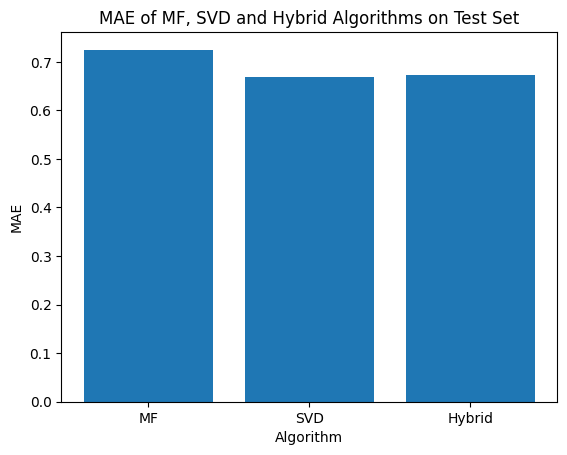

In [99]:

from surprise import accuracy

mf_predictions = mf_algo.test(testset)
mf_mae = accuracy.mae(mf_predictions, verbose=False)

svd_predictions = svd_algo.test(testset)
svd_mae = accuracy.mae(svd_predictions, verbose=False)

hybrid_predictions = hybrid_algo.test(testset)
hybrid_mae = accuracy.mae(hybrid_predictions, verbose=False)

plt.bar(['MF', 'SVD', 'Hybrid'], [mf_mae, svd_mae, hybrid_mae])
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.title('MAE of MF, SVD and Hybrid Algorithms on Test Set')
plt.show()


In [100]:

mf_rmse = accuracy.rmse(mf_predictions, verbose=False)
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)
hybrid_rmse = accuracy.rmse(hybrid_predictions, verbose=False)


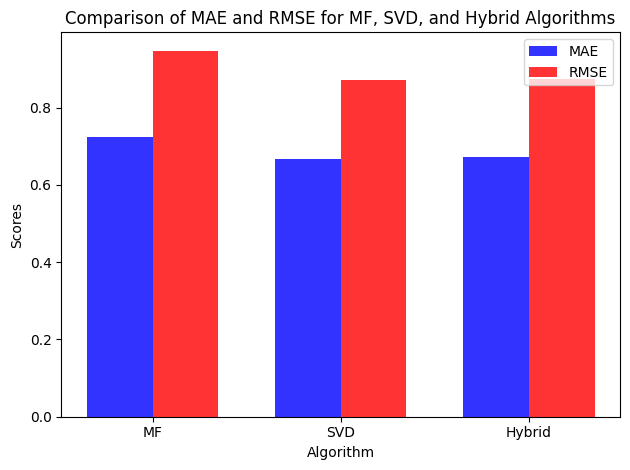

In [101]:

n_groups = 3
mae_scores = (mf_mae, svd_mae, hybrid_mae)
rmse_scores = (mf_rmse, svd_rmse, hybrid_rmse)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, mae_scores, bar_width,
                alpha=opacity, color='b',
                label='MAE')

rects2 = ax.bar(index + bar_width, rmse_scores, bar_width,
                alpha=opacity, color='r',
                label='RMSE')

plt.xlabel('Algorithm')
plt.ylabel('Scores')
plt.title('Comparison of MAE and RMSE for MF, SVD, and Hybrid Algorithms')
plt.xticks(index + bar_width / 2, ('MF', 'SVD', 'Hybrid'))
plt.legend()

plt.tight_layout()
plt.show()

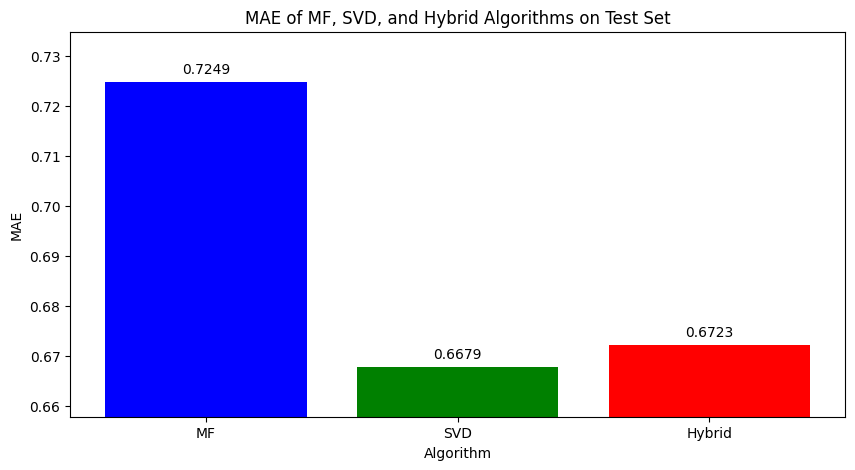

In [102]:

mae_scores = [mf_mae, svd_mae, hybrid_mae]
algorithms = ['MF', 'SVD', 'Hybrid']

# Visualizing the results
plt.figure(figsize=(10, 5))
plt.bar(algorithms, mae_scores, color=['blue', 'green', 'red'])
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.title('MAE of MF, SVD, and Hybrid Algorithms on Test Set')
plt.ylim(min(mae_scores) - 0.01, max(mae_scores) + 0.01)  # Set y-axis limits for better comparison
for i, v in enumerate(mae_scores):
    plt.text(i, v + 0.001, "{:.4f}".format(v), ha='center', va='bottom')
plt.show()


In [103]:

print(f'\nMAE of MF: {mf_mae}')
print(f'MAE of SVD: {svd_mae}')

print(f'MAE of Hybrid: {hybrid_mae}\n')


MAE of MF: 0.7248529964527394
MAE of SVD: 0.667914542963959
MAE of Hybrid: 0.6722776964441726



In [104]:

print(f'RMSE of MF: {mf_rmse}')
print(f'RMSE of SVD: {svd_rmse}')
print(f'RMSE of Hybrid: {hybrid_rmse}\n')


RMSE of MF: 0.9474443567766799
RMSE of SVD: 0.87117641140875
RMSE of Hybrid: 0.8751347415875295



In [105]:

print("MAE scores for each algorithm:")
for algo, score in zip(algorithms, mae_scores):
    print(f"{algo} MAE: {score:.4f}")
print()


MAE scores for each algorithm:
MF MAE: 0.7249
SVD MAE: 0.6679
Hybrid MAE: 0.6723



Based on the MAE, the SVD algorithm performs the best among the three, providing the most accurate predictions.

The Hybrid system does not significantly improve the individual rating outputs; its MAE is slightly higher than the SVD's MAE but lower than the MF's. This suggests that the Hybrid system is influenced more by the SVD's performance but is not able to leverage the combination to surpass it.

To improve the system a weighted average where the SVD's predictions are given more weight could improve the model, because it is the better-performing model.
Another approach is to implement a machine learning meta-model that learns how to best combine the predictions from the MF and SVD models based on the data.
Further hyperparameter optimization, possibly using a more exhaustive grid search or a randomized search, could fine-tune the models for better performance.
Incorporating more sophisticated models, that factor in user and item biases explicitly, could also be beneficial.

Assigning weights to the predictions in a Hybrid model would give more weight to the predictions of the algorithm that has proven to be more accurate on your validation set or through cross-validation.
The weights can be assigned based on past performance or learned from the data itself, using techniques like stacking, where a second model learns to optimally combine the outputs of each algorithm.